In [2]:
# 9.6.1 下载数据集(已经在9.6中准备好)

import os
import json
import numpy as np
import torch
import torchvision
from PIL import Image

import sys
sys.path.append("../d2lzh/") 
import d2lzh_pytorch as d2l

data_dir = '../Datasets/pikachu'

assert os.path.exists(os.path.join(data_dir, "train"))

In [17]:
# 9.6.2 读取数据集　

# 定义数据集类PikachuDetDataset,数据集每个样本：label+image
class PikachuDetDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, part, image_size=(256, 256)):
        assert part in ["train", "val"]
        self.image_size = image_size
        self.image_dir = os.path.join(data_dir, part, 'images')
        
        with open(os.path.join(data_dir, part, 'label.json')) as f:
            self.label = json.load(f)
            
        # 将 PIL 图片转换成位于[0.0, 1.0]的floatTensor, shape (C x H x W)
        self.transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
            ])
        
    def __len__(self):
        return len(self.label)
    
    
    def __getitem__(self, index):
        image_path = str(index + 1) + ".png"
        
        cls = self.label[image_path]["class"]
#         loc = self.label[image_path]["loc"]
        label = np.array([cls]+self.label[image_path]["loc"], dtype="float32")[None, :]
        
        PIL_img = Image.open(os.path.join(self.image_dir, image_path))
        PIL_img = PIL_img.convert('RGB').resize(self.image_size)
        img = self.transform(PIL_img)
        
        sample = {
            'label': label, # shape: (1, 5) [class, xmin, ymin, xmax, ymax]
            'image': img     # shape: (3, *image_size)
        }
        
        return sample
    
### 

def load_data_pikachu(batch_size, edge_size=256, data_dir='../Datasets/pikachu/'):
    """
    Function: 读取pikachu数据并用DataLoader进行封装
    
    
    """
    image_size = (edge_size, edge_size)
    train_dataset = PikachuDetDataset(data_dir, 'train', image_size)
    val_dataset = PikachuDetDataset(data_dir, 'val', image_size)
    
    train_iter = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True, num_workers=4)
    val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    return train_iter, val_iter       

In [15]:
# 读取小批量并打印图像＋标签形状

# 这里要注意的是小批量中每张图像的边界框个数不一致的问题．
# 比如图片１有一个边界框，图片２有两个边界框，那么需要为图片１填充一个非法边界框
# 当不同图片包含了相同的边界框，那么小批量读取就变得可能了

In [18]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_pikachu(batch_size, edge_size, data_dir)
batch = iter(train_iter).next()
print(batch["image"].shape, batch["label"].shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 5])


In [19]:
### 9.6.3 图示数据

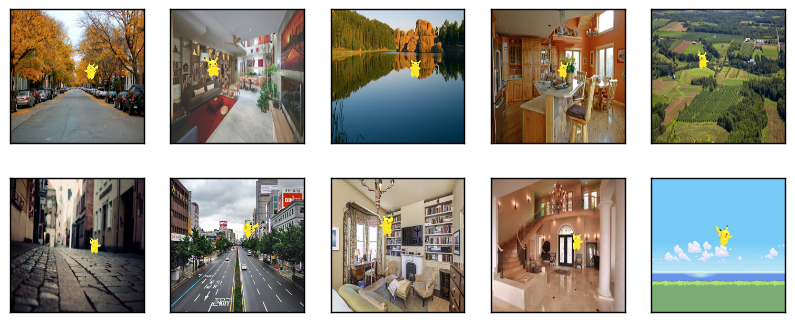

In [22]:
imgs = batch["image"][1:11].permute(0, 2, 3, 1)
bboxes = batch["label"][1:11, 0, 1:]

axes = d2l.show_images(imgs, 2, 5).flatten()
for ax, bb in zip(axes, bboxes):
    d2l.show_bboxes(ax, [bb*edge_size], colors=['w'])
d2l.plt.show()